# OpenDSS e Python: Um Estudo de Fluxo de Carga Hamônica
O objetivo deste tutorial é compilar algumas ferramentas e demonstrar as suas potencialidade de uso.

## Simulação

In [1]:
import opendssdirect as dss
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

O circuito simulado é um trecho do sistema IEEE de 13 barras. A carga foi modificada para ser uma fonte harmônica e a curva de carga utilizada é um exemplo fornecido pelo próprio OpenDSS chamado LoadShape1.csv

![Circuito simulado](Imagens/circuito.png)

In [2]:
file = 'Estudo_de_Caso_2.dss'
dss.run_command('Redirect ' + file)

''

In [3]:
dss.utils.loads_to_dataframe()

,AllocationFactor,CFactor,CVRCurve,CVRvars,CVRwatts,Class,Daily,Duty,Growth,Idx,...,Xneut,Yearly,ZipV,kV,kVABase,kW,kWh,kWhDays,kvar,puSeriesRL
671,0.5,4,,2,1,1,,,,1,...,0,,[],4.16,1330.27,1155,0,30,660,50


In [4]:
load_shape_file_path = 'LoadShape1.CSV'
load_shape = pd.read_csv(load_shape_file_path) 
load_shape.head()

,Pot_pu
0,0.544181
1,0.503066
2,0.473728
3,0.457491
4,0.454773


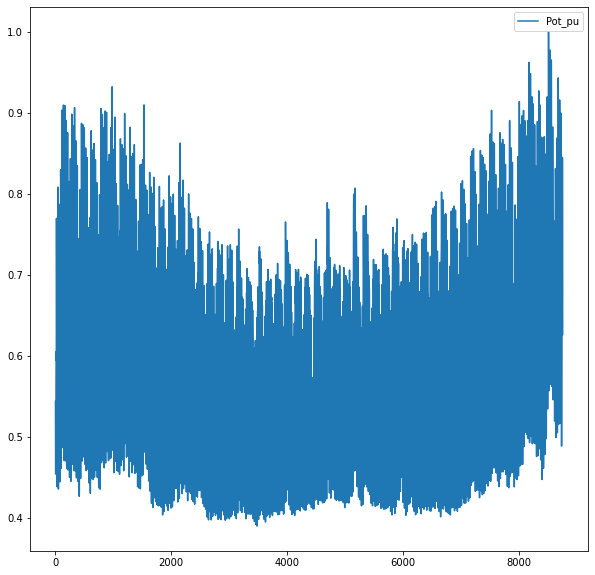

In [5]:
plt.figure(figsize=(10,10))
sns.lineplot(data=load_shape)

In [6]:
result = []
S = (1155**2 + 660**2)**0.5
for i in range(0, len(load_shape)):
    dss.run_command('Load.671.kw='+str( (S * load_shape.Pot_pu[i]) * (1155/S) ) )
    dss.run_command('Load.671.kvar='+str( (S * load_shape.Pot_pu[i]) * (660/S) ) )
    dss.run_command('Set mode=snap')
    dss.run_command('Solve')
    dss.run_command('Set mode=harmonic')
    dss.run_command('Solve')
    try:
        #dss.run_command('Show monitor MPAC')
        dss.run_command('Export monitors mpac')
    except:
        pass
    result.append(pd.read_csv('IEEE13_EC2_Mon_mpac.csv'))
    

In [7]:
result[0].head()

,Freq,Harmonic,V1,VAngle1,V2,VAngle2,V3,VAngle3,I1,IAngle1,I2,IAngle2,I3,IAngle3
0,60,1.0,2401.940000,-0.002037,2401.940000,-120.0020,2401.940000,119.9980,101.969000,-30.5305,101.968000,-150.5310,101.968000,89.469500
1,180,3.0,0.000145,-15.354800,0.000382,97.5653,0.000351,-104.7060,0.043063,78.8203,0.113617,-168.2600,0.104653,-10.531300
2,300,5.0,0.091584,-168.382000,0.089971,-48.9337,0.091544,70.4701,16.392200,-75.8742,16.103500,43.5742,16.385000,162.978000
3,420,7.0,0.113763,50.010600,0.115562,-71.1481,0.112660,168.6350,14.551200,141.8030,14.781200,20.6438,14.410000,-99.573600
4,540,9.0,0.000402,-31.867000,0.002496,96.7646,0.002267,-91.2010,0.040010,59.5270,0.248341,-171.8420,0.225538,0.192885


## Análise dos resultados
A partir deste ponto, a simulação finalizou e podemos realizar todas as análises dos dados pertinentes.
A título de exemplo, vamos analisar a tensão V1 e verificar o comportamento hamônico perante a variação da potência da carga. Inicialmente vamos compilar os módulos de V1 para cada uma das frequências em um DataFrame onde cada coluna é uma frequência, esse procedimento  facilitará a manipulação dos dados.

In [8]:
espectro = pd.DataFrame()
coluna = ' V1'
for i in range(0, len(result[0][coluna])):
    column = result[0].Freq[i]
    voltage = []
    for j in range(0, len(result)):
        voltage.append(result[j].loc[result[j].Freq == column, coluna][i])
    espectro[column] = voltage
        

O procedimento anterior permite criar o DataFrame espectro, em que cada célula armazena um módulo de tensão, cada coluna é uma frequência e cada linha representa um patamar, uma vez que realizamos uma simulação para cada patamar (totalizando 8760 linhas).

In [9]:
espectro.head()

,60,180,300,420,540,660,780,900
0,2401.94,0.000145,0.091584,0.113763,0.000402,0.109679,0.114181,0.005029
1,2401.94,0.000123,0.084695,0.105283,0.000343,0.101449,0.105748,0.004279
2,2401.95,0.000109,0.079775,0.099221,0.000303,0.095569,0.099709,0.003782
3,2401.95,0.000102,0.077052,0.095861,0.000282,0.092312,0.096360,0.003521
4,2401.95,0.000101,0.076596,0.095299,0.000279,0.091766,0.095798,0.003478


Podemos obter algumas informações estatísticas relacionadas a esse DataFrame, informações como total de linhas, média, desvio, valor mínimo, máximo e percentis. 

In [10]:
espectro.describe()

,60,180,300,420,540,660,780,900
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,2401.927878,0.000191,0.102923,0.127639,0.000532,0.123175,0.127875,0.006681
std,0.018399,0.000073,0.020033,0.024581,0.000205,0.023881,0.024344,0.002599
min,2401.870000,0.000074,0.065822,0.081988,0.000205,0.078874,0.082504,0.002547
25%,2401.910000,0.000126,0.085500,0.106276,0.000349,0.102412,0.106736,0.004363
50%,2401.920000,0.000196,0.106431,0.131995,0.000548,0.127390,0.132258,0.006866
75%,2401.940000,0.000239,0.117089,0.145047,0.000666,0.140082,0.145151,0.008373
max,2401.960000,0.000500,0.167599,0.206487,0.001401,0.199877,0.205231,0.017721


As estatíticas anteriores mostram que o valor de tensão para a frequência fundamental é muito superior as demais, vamos removê-la para não prejudicar os gráficos.

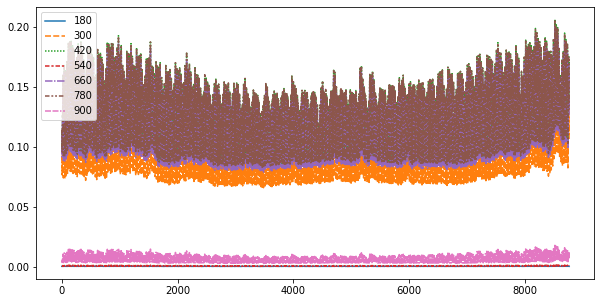

In [11]:
feature = []
for col in espectro.columns:
    if col != 60:
        feature.append(col)
        
plot = espectro[feature]
plt.figure(figsize=(10,5))
sns.lineplot(data=plot)

O plot anterior não permite extrair muitas informações a respeito do resultado. Entretanto, por estarmos em um ambiente de programação, muitas análises podem ser feitas facilmente. A seguir vamos verificar um histograma que mostra quais foram os valores de módulo que mais apareceram na frequência de 180 Hz.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


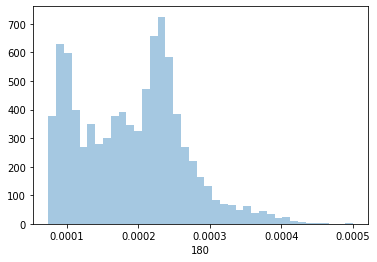

In [12]:
sns.distplot(a=espectro[180], kde=False)

Podemos criar também um histograma para os patamares e verificar quais foram os valores de potência que mais se repetiram.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


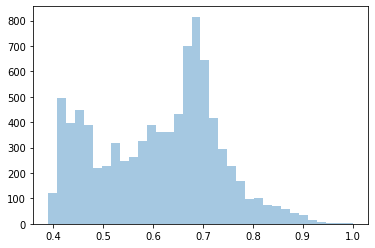

In [14]:
sns.distplot(a=load_shape, kde=False)

Empiricamente é possível notar que ambos os espectros possuem um comportamento bem semelhante, ou seja, quando um sobe, o outro também sobe e quando um desce, o outro também desce. É possível validar esse comportamento por meio de uma correlação entre os dois. A célula a seguir calcula a correção entre eles, é possível notar que são bastante diretamente correlacionados, uma vez que estão bem próximos de 1.

In [16]:
correlacao = pd.DataFrame()
correlacao[180] = espectro[180]
correlacao['Pot_pu'] = load_shape['Pot_pu']
correlacao.corr()

,180,Pot_pu
180,1.000000,0.993536
Pot_pu,0.993536,1.000000
